In [1]:
import glob

import pandas as pd
import numpy as np
import scanpy as sc
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pathlib
import celltypist
from celltypist import models
params = {
    'font.size': 12,
    'axes.titlesize': 12,
    'axes.labelsize': 12,
    'legend.fontsize': 12,
    'xtick.labelsize': 8,
    'ytick.labelsize': 10,
    'font.family': "Arial",
    'pdf.fonttype': 42,
    'ps.fonttype': 42,
    'figure.dpi': 100
   }

tissue = 'PB'
mpl.rcParams.update(params)
sns.set_style("ticks")
sns.set_context(context='paper')
savefig_args = {"dpi": 300, "bbox_inches": "tight", "pad_inches": 0, "transparent": True}
mpl.rc('savefig', dpi=300)
output_dir='figures/QCandAnnotation/{}'.format(tissue)
pathlib.Path(output_dir).mkdir(parents=True, exist_ok=True)
output_suffix = ""
output_formats = [".png", ".svg"]
sc.settings.figdir = output_dir
sc.set_figure_params(format='pdf', transparent=True,)
def save_figure(fig, name, output_dir=output_dir, output_suffix=output_suffix, output_formats=output_formats, savefig_args=savefig_args):
    for output_format in output_formats:
        fig.savefig(output_dir + "/" + name + output_suffix + output_format, **savefig_args)
    return None

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 20) 
pd.set_option('display.width', 100)
%load_ext autoreload
%autoreload 2

In [1]:
%run ../_helper.py

In [2]:
vdj_df = pd.read_table("/home/michaelswift/repos/shared_data/tbd_share/vdj_integrated_with_flags.tsv.gz", index_col=0)

<ipython-input-2-e00e7bdcef57>:1: DtypeWarning: Columns (2,3,4,5,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,46,54,56,58,59,60,63,73,74,75,76,77,78,79,82,83,91) have mixed types. Specify dtype option on import or set low_memory=False.
  vdj_df = pd.read_table("/home/michaelswift/repos/shared_data/tbd_share/vdj_integrated_with_flags.tsv.gz", index_col=0)


In [3]:
def merge_vdj(adata, vdj_df):
    vdj_df = vdj_df.reset_index()
    # prepare merge
    vdj_df['cb_suid'] = vdj_df['cb'] + "_" + vdj_df['sample_uid']
    # remove duplicates
    vdj_df = vdj_df[~vdj_df['cb_suid'].duplicated()]    
    obs_df = adata.obs
    obs_df['cb'] = pd.Series(obs_df.index).str.split('-', expand = True)[0].values
    obs_df['cb_suid'] = obs_df['cb'].astype(str) + "_" + obs_df['sample_uid'].astype(str)
    obs_df.set_index('cb_suid', inplace = True)
    vdj_df.set_index('cb_suid', inplace = True)

    # merge
    obs_df = pd.merge(obs_df, vdj_df, left_index=True, right_index=True, how = 'left', suffixes=[None, "_vdj"])
    adata.obs = obs_df
    return adata

In [5]:
data_path = "/home/michaelswift/repos/tabula-bursa/analysis/notebooks/by_tissue_qc/outputs/tissue_objs/"
for file in glob.glob(data_path+"*"):
    print(file)
    # do the routine:
    # load data
    if tissue in file:
        adata = sc.read_h5ad(file)
        adata = merge_vdj(adata, vdj_df)
        # remove IGH and IGL variable genes from highly variable genes for clustering analysis 
        adata.var.loc[adata.var.index.str.contains("IGHV|IGLV|IGKV|FOS|JUN|HSP|RPL"), 'highly_variable'] = False
        # ad hoc exclusion of weird samples
        adata = adata[adata.obs.sample_uid != 'TBd3_fresh_B200']

/home/michaelswift/repos/tabula-bursa/analysis/notebooks/by_tissue_qc/outputs/tissue_objs/LN_processed.h5ad
/home/michaelswift/repos/tabula-bursa/analysis/notebooks/by_tissue_qc/outputs/tissue_objs/SP_processed.h5ad
/home/michaelswift/repos/tabula-bursa/analysis/notebooks/by_tissue_qc/outputs/tissue_objs/BM_processed.h5ad
/home/michaelswift/repos/tabula-bursa/analysis/notebooks/by_tissue_qc/outputs/tissue_objs/filtered
/home/michaelswift/repos/tabula-bursa/analysis/notebooks/by_tissue_qc/outputs/tissue_objs/PB_processed.h5ad


... storing 'cb' as categorical
... storing 'sample_uid_vdj' as categorical
... storing 'cb_vdj' as categorical
... storing 'locus' as categorical
... storing 'vdjc_info' as categorical
... storing 'vdj_sequence' as categorical
... storing 'c_call' as categorical
... storing 'stop_codon' as categorical
... storing 'vj_in_frame' as categorical
... storing 'productive' as categorical
... storing 'v_call' as categorical
... storing 'd_call' as categorical
... storing 'j_call' as categorical
... storing 'sequence_alignment' as categorical
... storing 'germline_alignment' as categorical
... storing 'sequence_alignment_aa' as categorical
... storing 'germline_alignment_aa' as categorical
... storing 'v_sequence_alignment' as categorical
... storing 'v_sequence_alignment_aa' as categorical
... storing 'v_germline_alignment' as categorical
... storing 'v_germline_alignment_aa' as categorical
... storing 'd_sequence_alignment' as categorical
... storing 'd_sequence_alignment_aa' as categorical


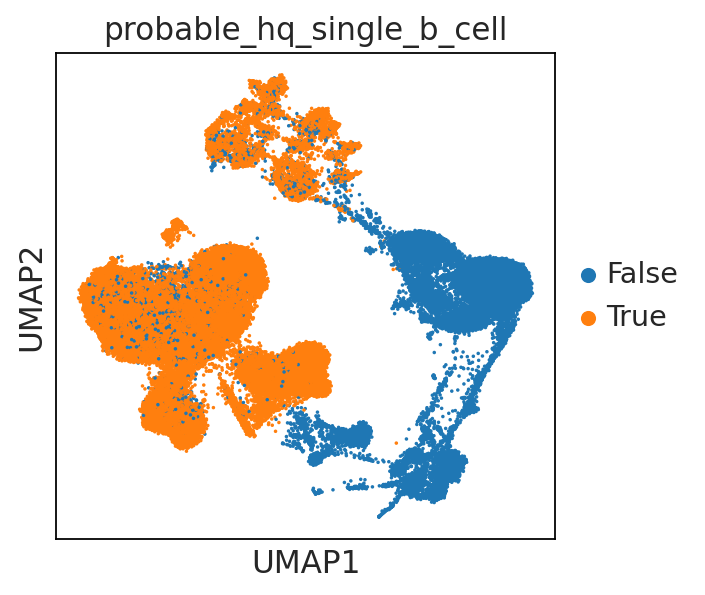

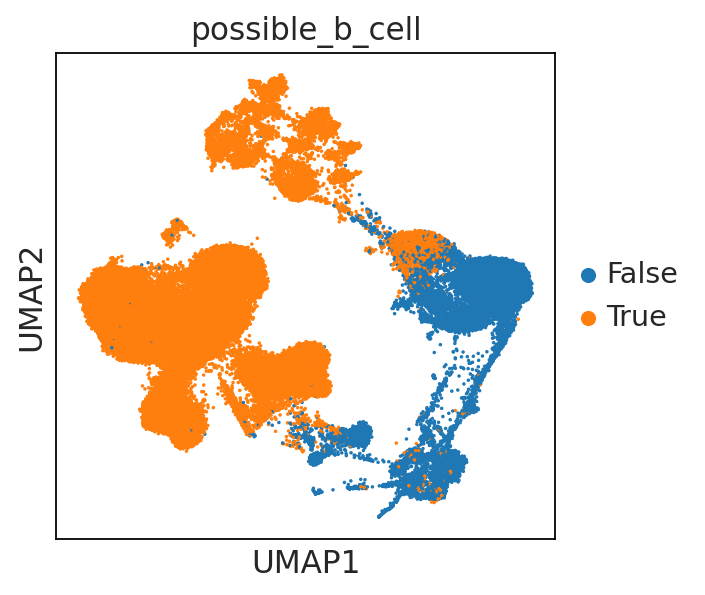

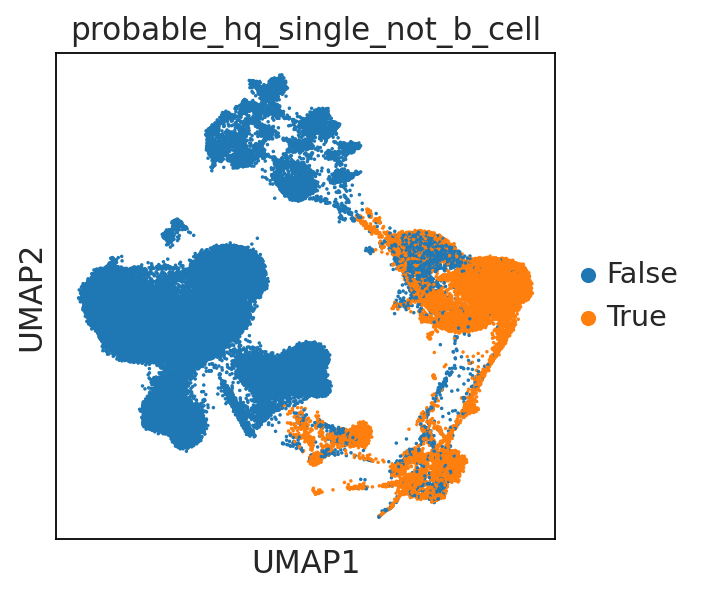

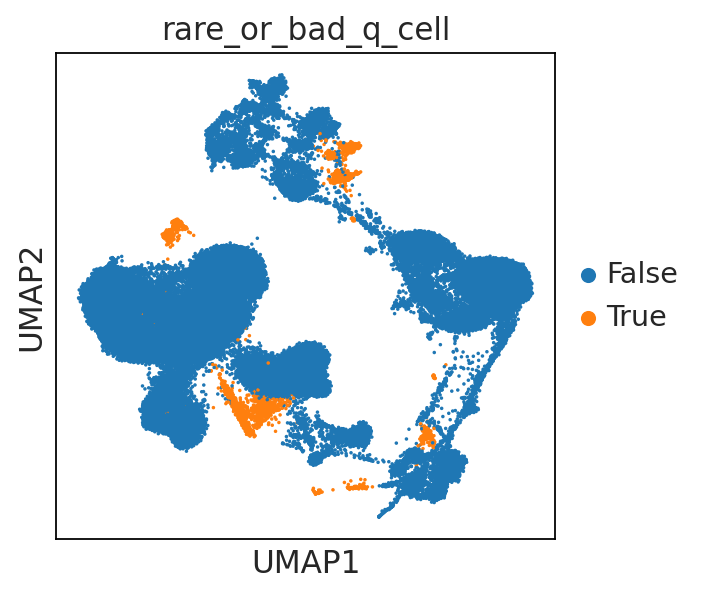

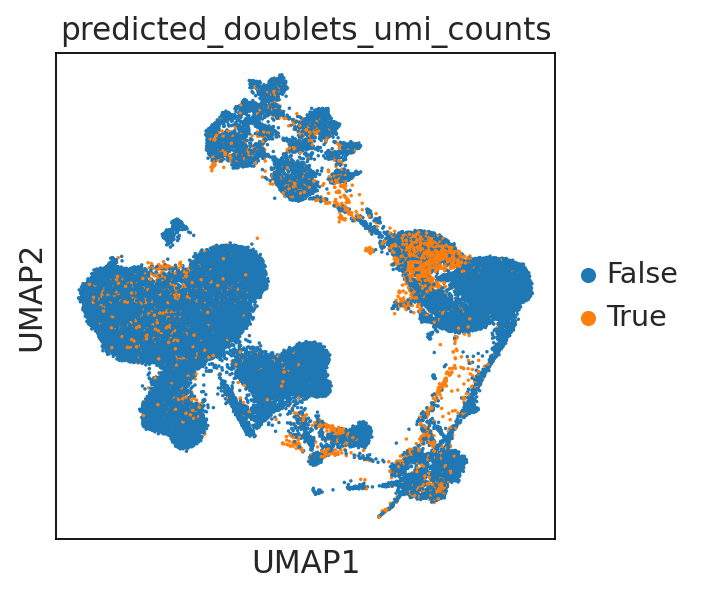

In [6]:
#variables = ['ambient_status', 'predicted_labels', 'v_identity', 'donor']
variables = ['probable_hq_single_b_cell', "possible_b_cell", "probable_hq_single_not_b_cell", "rare_or_bad_q_cell", 'predicted_doublets_umi_counts']
for var in variables:
    adata.obs[var] = adata.obs[var].astype(str).astype('category')
for var in variables:
    sc.pl.umap(adata, color = var, size = 10, save = "{}_{}".format(var, tissue))

## umis by celltype

In [7]:
adata.obs['log_n_umis'] = np.log(adata.obs['n_umis'])

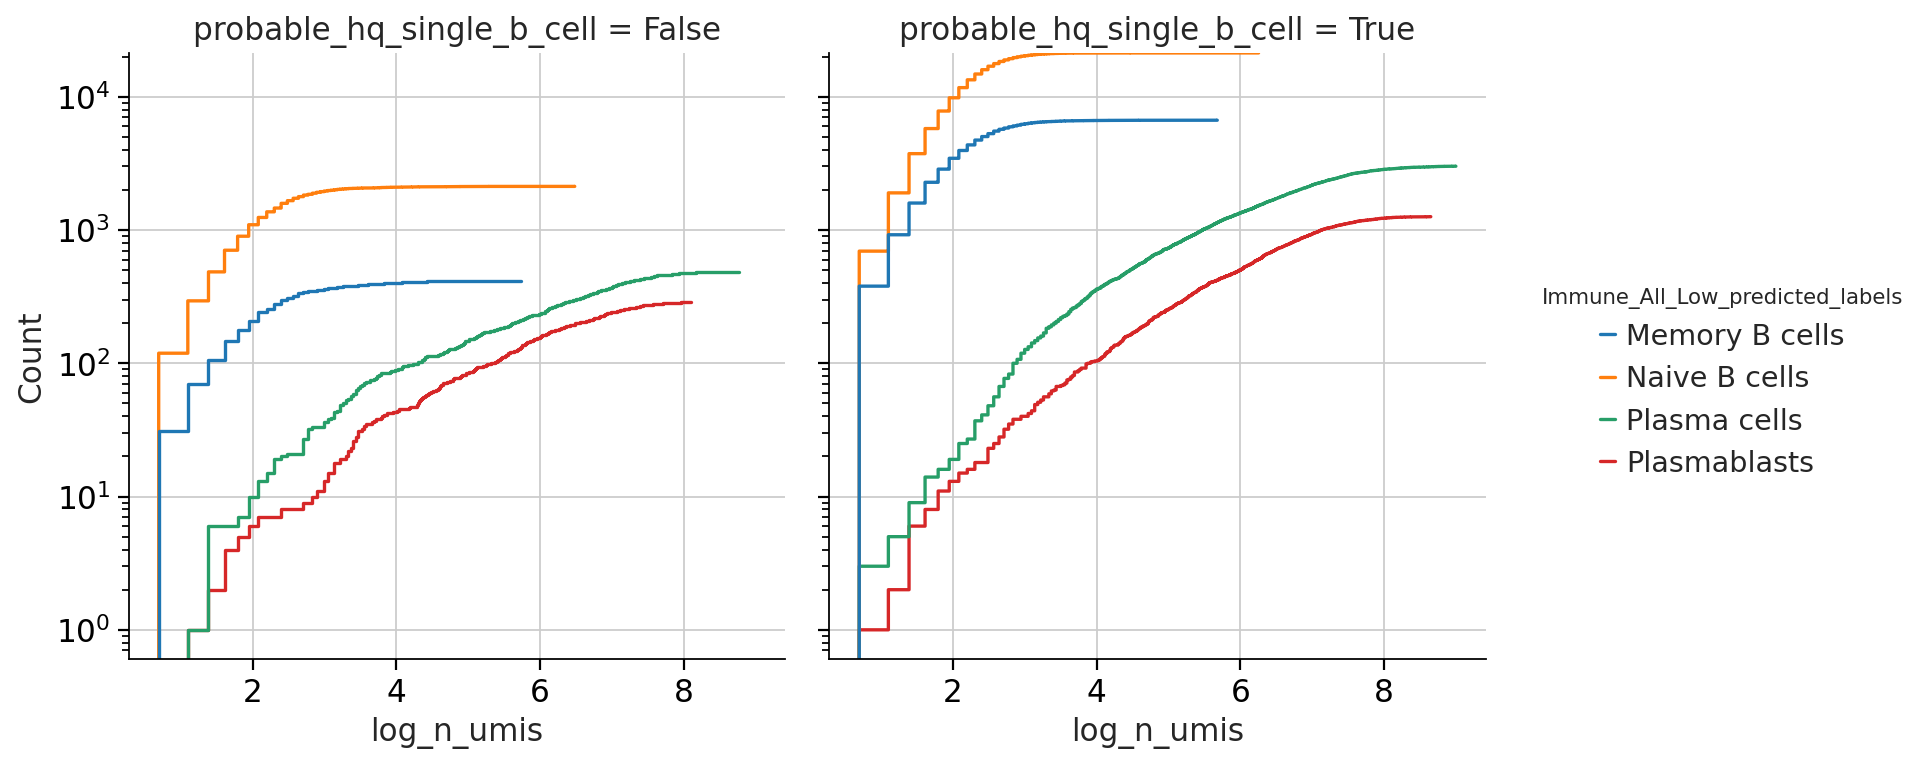

In [8]:
hue = 'Immune_All_Low_predicted_labels'
data = adata.obs[adata.obs[hue].str.contains("Naive B|Memory B|Plasma")]
data[hue].cat.remove_unused_categories(inplace = True)
kind = 'ecdf'
x = "log_n_umis"

g = sns.displot(data = data, x = x, kind = kind, hue = hue, col='probable_hq_single_b_cell', stat = 'count')
plt.yscale('log')
save_figure(g.fig, "{}_n_umis_{}".format(x,kind,hue))

In [9]:
sc.tl.rank_genes_groups(adata, groupby='{}_leiden'.format(tissue))

/home/michaelswift/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/home/michaelswift/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/home/michaelswift/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/tools/_rank_gene

In [29]:
# create ismple mutation status column
adata.obs.v_identity = adata.obs.v_identity.fillna(100)
adata.obs.loc[:,"simple_mutation_status"] = pd.cut(adata.obs.v_identity, bins = [0, 99, 100])

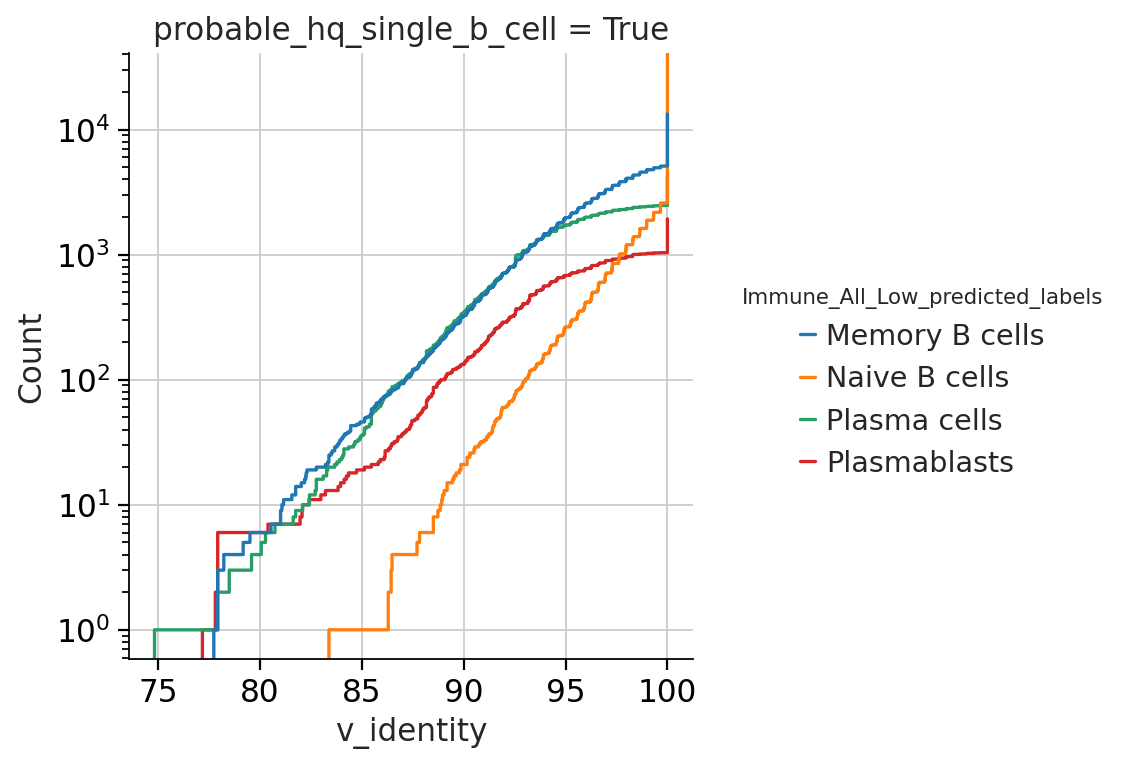

In [30]:
hue = 'Immune_All_Low_predicted_labels'
data = adata.obs[adata.obs[hue].str.contains("Naive B|Memory B|Plasma")]
data[hue].cat.remove_unused_categories(inplace = True)
kind = 'ecdf'
x = "v_identity"

g = sns.displot(data = data, x = x, kind = kind, hue = hue, col='probable_hq_single_b_cell', stat = 'count')
plt.yscale('log')
save_figure(g.fig, "{}_n_umis_{}".format(x,kind,hue))

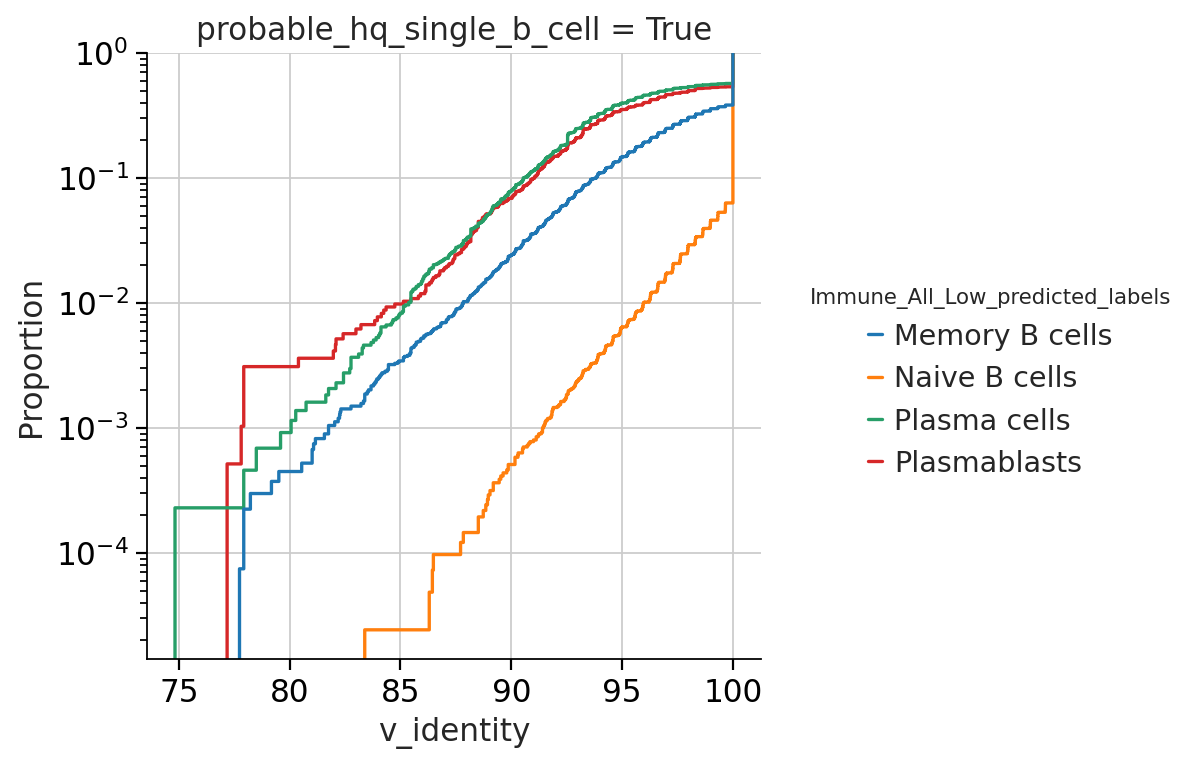

In [31]:
hue = 'Immune_All_Low_predicted_labels'
data = adata.obs[adata.obs[hue].str.contains("Naive B|Memory B|Plasma")]
data[hue].cat.remove_unused_categories(inplace = True)
kind = 'ecdf'
x = "v_identity"

g = sns.displot(data = data, x = x, kind = kind, hue = hue, col='probable_hq_single_b_cell', stat = 'proportion')
plt.yscale('log')
save_figure(g.fig, "{}_n_umis_{}".format(x,kind,hue))

In [32]:
adata = adata[adata.obs.probable_hq_single_b_cell == "True"]

In [43]:
adata.obs.my_leiden_majority_voting

cb_suid
AAACCTGAGAACTGTA_TBd3_fresh_P50     Naive B cells
AAACCTGAGACAGACC_TBd3_fresh_P50     Naive B cells
AAACCTGAGCACAGGT_TBd3_fresh_P50     Naive B cells
AAACCTGAGCCACCTG_TBd3_fresh_P50     Naive B cells
AAACCTGAGCTTATCG_TBd3_fresh_P50     Naive B cells
                                        ...      
TTTGTCAGTTTAGCTG_TBd6_fresh_PBMC    Naive B cells
TTTGTCATCATTCACT_TBd6_fresh_PBMC     Plasma cells
TTTGTCATCCGCATCT_TBd6_fresh_PBMC    Naive B cells
TTTGTCATCGTTACGA_TBd6_fresh_PBMC    Naive B cells
TTTGTCATCTTCTGGC_TBd6_fresh_PBMC    Naive B cells
Name: my_leiden_majority_voting, Length: 63754, dtype: category
Categories (2, object): ['Naive B cells', 'Plasma cells']

Naive B cells


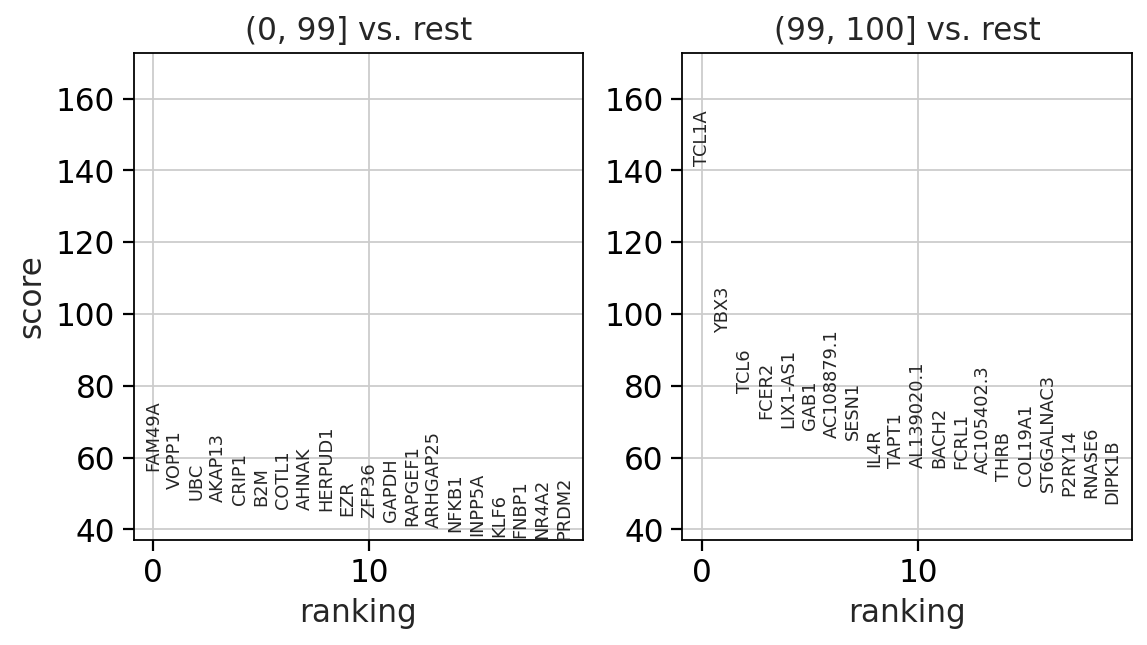

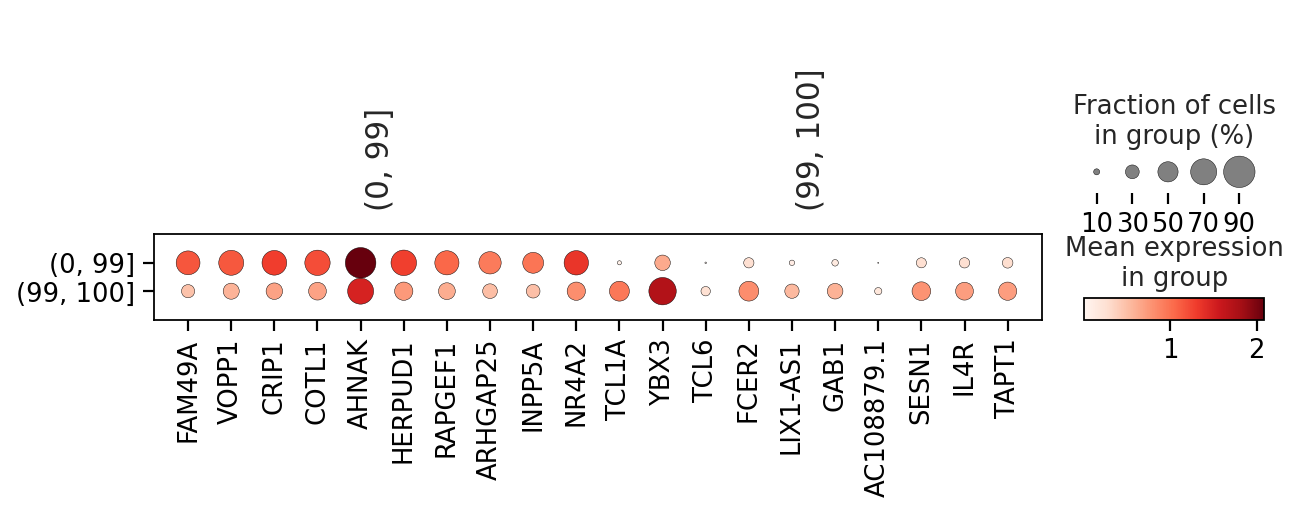

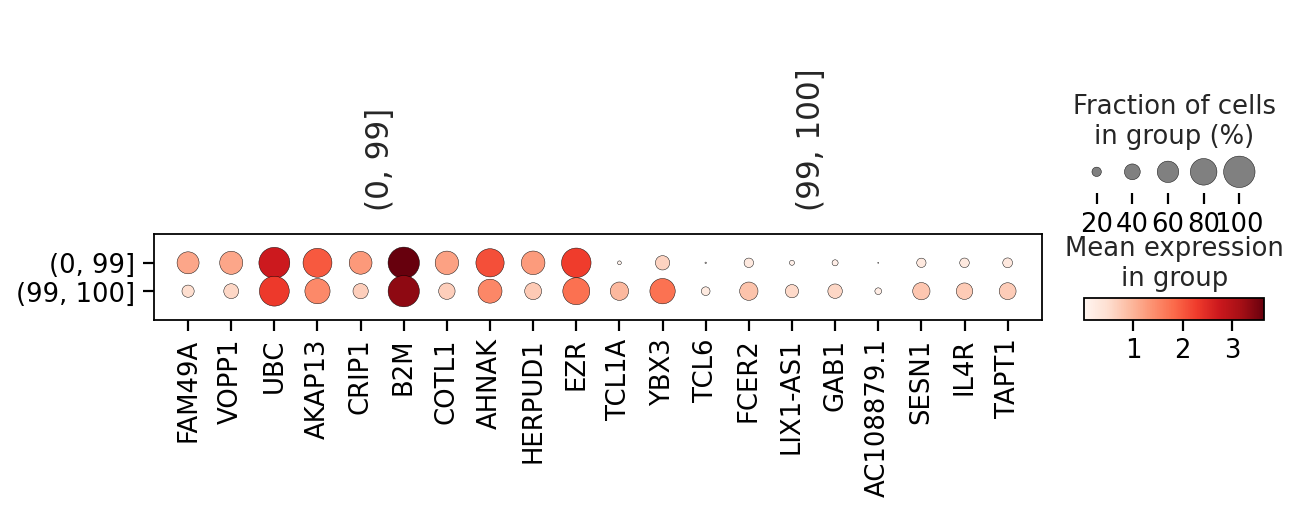


 
 
 

Plasma cells


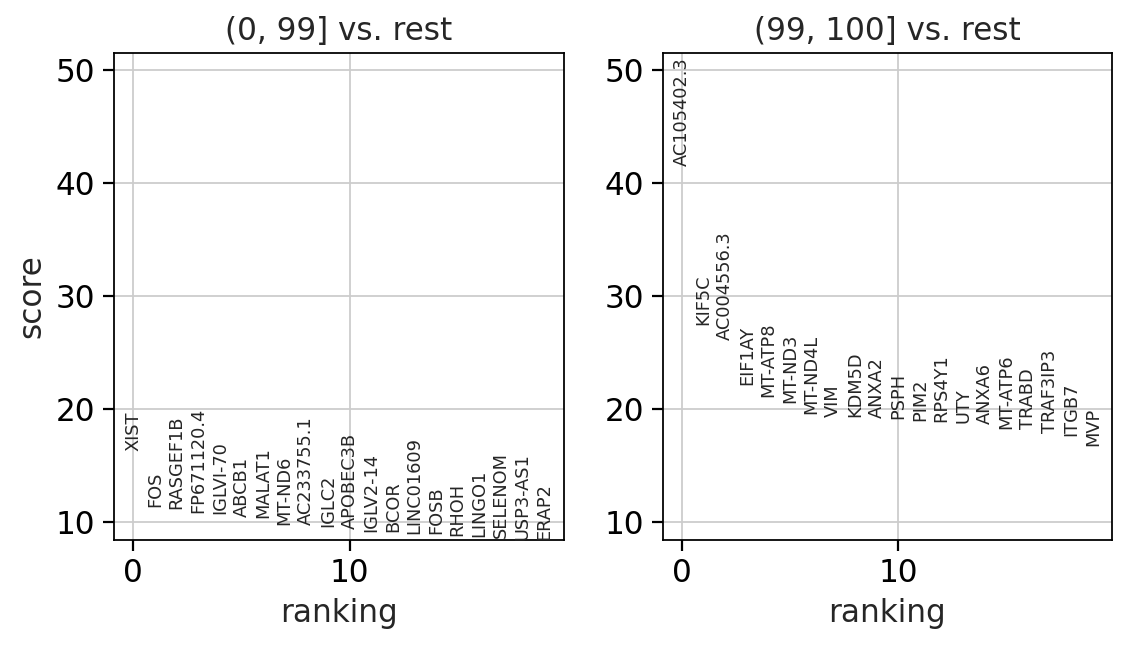

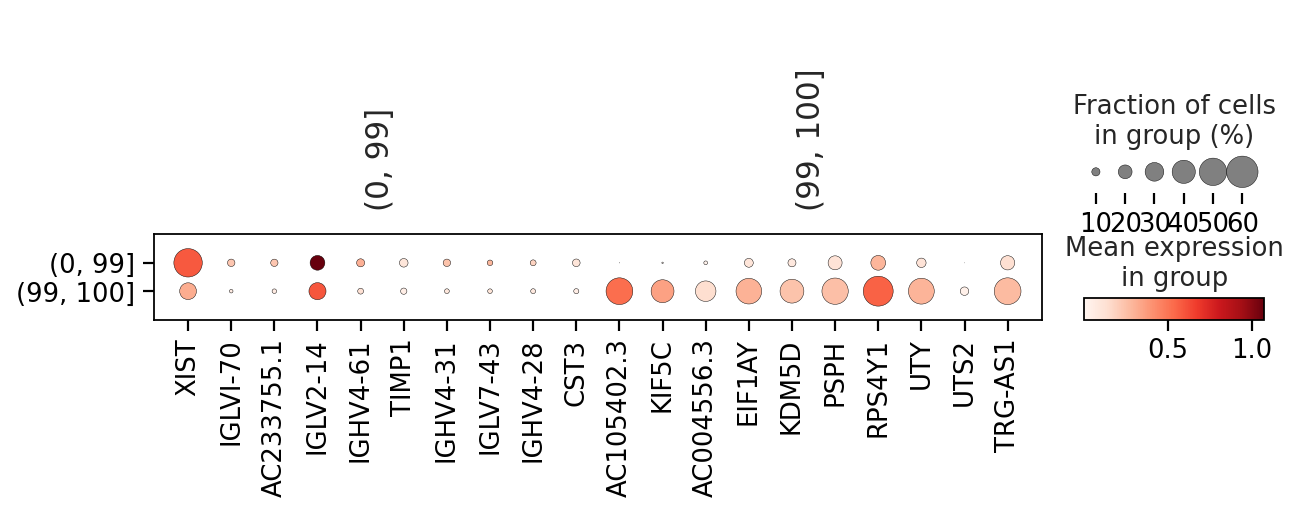

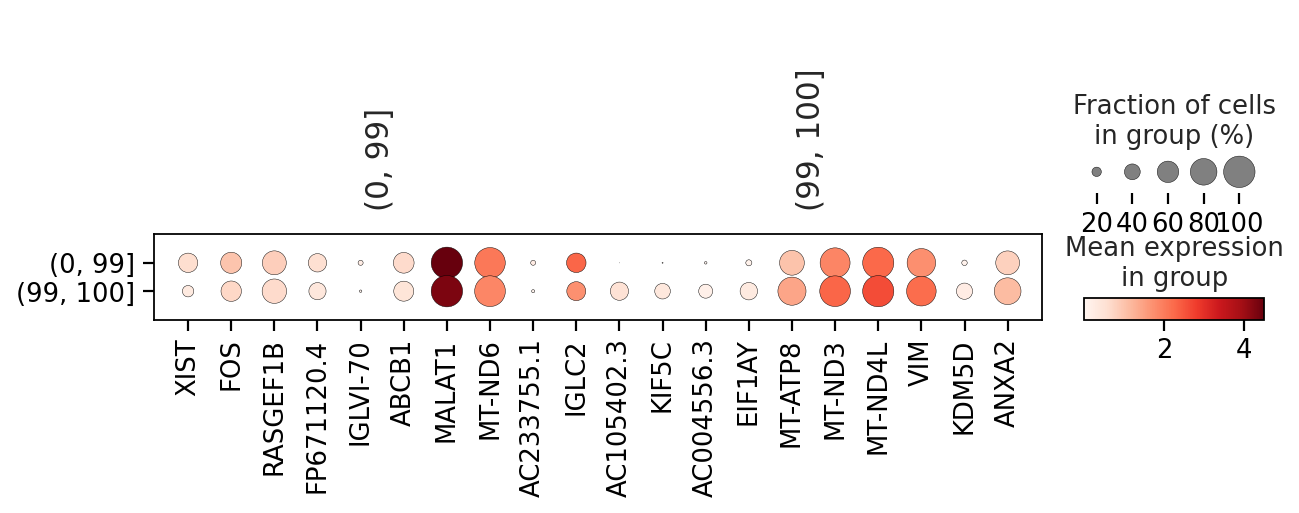

In [44]:
# subset adata
label = "my_leiden_majority_voting"
groupby = 'simple_mutation_status'
for celltype in adata.obs[label].cat.remove_unused_categories().unique():
    try:
        print(celltype)
        subset_adata = adata[adata.obs[label] == celltype]
        sc.tl.rank_genes_groups(subset_adata, groupby=groupby)
        sc.pl.rank_genes_groups(subset_adata)
        sc.pl.rank_genes_groups_dotplot(subset_adata, min_logfoldchange=1)
        sc.pl.rank_genes_groups_dotplot(subset_adata)
    except:
        pass
    print("\n \n \n \n")

In [45]:
adata.obs

,sample_uid,n_genes,n_counts,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,total_counts_mt,log1p_total_counts_mt,pct_counts_mt,...,LN_leiden,BM_leiden,SP_leiden,bcell_subtype,multiplet_status,ambient_status,gex_status,vdj_sequence_in_ambient,log_n_umis,simple_mutation_status
cb_suid,,,,,,,,,,,,,,,,,,,,,
AAACCTGAGAACTGTA_TBd3_fresh_P50,TBd3_fresh_P50,1181,2058.0,1181,7.074963197966044,2058.0,7.629976,44.0,3.8066626,2.137998,...,NaN,NaN,NaN,Naive B cells,0.0,no informative GEX information,GEX only,False,NaN,"(99, 100]"
AAACCTGAGACAGACC_TBd3_fresh_P50,TBd3_fresh_P50,1032,2164.0,1032,6.940222469119639,2164.0,7.680176,53.0,3.988984,2.4491682,...,NaN,NaN,NaN,Naive B cells,1.0,high quality B cell,both available,False,1.945910,"(99, 100]"
AAACCTGAGCACAGGT_TBd3_fresh_P50,TBd3_fresh_P50,2883,9984.0,2883,7.96693349840484,9984.0,9.208839,160.0,5.081404,1.6025642,...,NaN,NaN,NaN,Memory B cells,1.0,high quality B cell,both available,False,3.583519,"(99, 100]"
AAACCTGAGCCACCTG_TBd3_fresh_P50,TBd3_fresh_P50,923,2257.0,923,6.828712071641684,2257.0,7.7222347,71.0,4.276666,3.145769,...,NaN,NaN,NaN,Naive B cells,0.0,no informative GEX information,GEX only,False,NaN,"(99, 100]"
AAACCTGAGCTTATCG_TBd3_fresh_P50,TBd3_fresh_P50,1178,2260.0,1178,7.072421900537371,2260.0,7.7235622,54.0,4.0073333,2.3893805,...,NaN,NaN,NaN,Naive B cells,0.0,no informative GEX information,GEX only,False,NaN,"(99, 100]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTCAGTTTAGCTG_TBd6_fresh_PBMC,TBd6_fresh_PBMC,2163,5391.0,2163,7.679713639966372,5391.0,8.592671,145.0,4.983607,2.689668,...,NaN,NaN,NaN,Naive B cells,0.0,no informative GEX information,GEX only,False,NaN,"(99, 100]"
TTTGTCATCATTCACT_TBd6_fresh_PBMC,TBd6_fresh_PBMC,4839,31157.0,4839,8.484669999710677,31157.0,10.346827,740.0,6.6080008,2.3750682,...,NaN,NaN,NaN,Plasma cells,0.0,no informative GEX information,GEX only,False,NaN,"(99, 100]"
TTTGTCATCCGCATCT_TBd6_fresh_PBMC,TBd6_fresh_PBMC,1940,4226.0,1940,7.57095858316901,4226.0,8.349248,98.0,4.59512,2.3189778,...,NaN,NaN,NaN,Naive B cells,0.0,no informative GEX information,GEX only,False,NaN,"(99, 100]"


In [27]:
subset_adata = adata[adata.obs.Immune_All_Low_predicted_labels == "Memory B cells"]